## Контрольная работа CVDL, 17.10.23
Вам необходимо обучить многоклассовый классификатор изображений на train части датасета, находящегося в DATASET_PATH.
Также надо проверить что обучение сошлось, и замерять метрики на test.

Баллы:
 - работающий код тренировки с правильным лоссом и головой для задачи многоклассовой классификации: **4** балла
 - метрики precision/recall по классам по train и test: **2** балла
 - график train и test лоссов: **2** балла
 - отсутствие оверфита по графикам train-test (т.е кратной разницы лоссов и метрик): **1** балл
 - precision и recall (c average='macro') - на test оба выше 0.7: **1** балл

Предполагается, что вы используете предобученную модель и затюните ее. Датасеты train и тест маленькие, всего по  2500 изображений, так что обучение сети с нуля приведет к оверфиту.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install unrar
!unrar x '/content/gdrive/MyDrive/GroceryStoreDataset.rar'

Выходные данные были обрезаны до нескольких последних строк (5000).
Extracting  GroceryStoreDataset/dataset/test/Fruit/Orange/Orange_018.jpg      56%  OK 
Extracting  GroceryStoreDataset/dataset/test/Fruit/Orange/Orange_019.jpg      56%  OK 
Extracting  GroceryStoreDataset/dataset/test/Fruit/Orange/Orange_020.jpg      56%  OK 
Extracting  GroceryStoreDataset/dataset/test/Fruit/Orange/Orange_021.jpg      56%  OK 
Extracting  GroceryStoreDataset/dataset/test/Fruit/Orange/Orange_022.jpg      56%  OK 
Extracting  GroceryStoreDataset/dataset/test/Fruit/Orange/Orange_023.jpg      56%  OK 
Extracting  GroceryStoreDataset/dataset/test/Fruit/Orange/Orange_024.jpg      56%  OK 
Extracting  GroceryStoreDataset/dataset/test/Fruit/Orange/Orange_025.jpg      56%  OK 
Extracting  GroceryStoreDataset/dataset/test/Fruit/Orange/Orange_026.jpg      56%  OK 
Extracting  GroceryStoreDataset/dataset/test/Fruit/Orange/Orange_027

In [3]:
from pathlib import Path

#######
DATASET_PATH = '/content/GroceryStoreDataset/dataset'
#######

DATASET_PATH = Path(DATASET_PATH)
assert DATASET_PATH.exists()

In [4]:
import pandas

In [5]:
import torch
import numpy as np
from tqdm import tqdm

In [6]:
from torchvision.datasets.folder import DatasetFolder, default_loader
from typing import Optional, Callable, Tuple, Any, List
import pandas as pd


class FoodDataset(DatasetFolder):
    def __init__(self,
            root: str,
            classes_path: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            ):
        super().__init__(root=root, transform=transform, loader=default_loader, target_transform=target_transform, extensions='')
        self.root = Path(root)
        self._image_paths = self.find_images_recursively(self.root)
        self._classes_map = pd.read_csv(classes_path).set_index('Class Name (str)')['Coarse Class Name (str)']
        self._image_labels = [self.determine_sample_label(self.root, ip) for ip in self._image_paths]
        self.classes = list(dict.fromkeys(self._classes_map))
        self.samples = [
            (sample_path, self.classes.index(sample_cls))
            for (sample_path, sample_cls) in zip(self._image_paths, self._image_labels)
        ]

    def find_images_recursively(self, root_path):
        files = list(root_path.glob("[!.]*"))
        samples = list(f for f in files if not f.is_dir())
        subdirs = list(f for f in files if f.is_dir())
        assert len(samples) == 0 or len(subdirs) == 0, f"Can't mix subdirs and images"
        if len(subdirs):
            samples = []
            for sub_root_path in subdirs:
                samples += self.find_images_recursively(sub_root_path)
        return samples

    def determine_sample_label(self, root_path, sample_path):
        parts = sample_path.relative_to(root_path).parent.parts
        precise_label = parts[-1]
        coarse_label = self._classes_map[precise_label]
        return coarse_label

In [7]:
ds_train = FoodDataset(DATASET_PATH / 'train', DATASET_PATH / 'classes.csv')
ds_test = FoodDataset(DATASET_PATH / 'test', DATASET_PATH / 'classes.csv')
print(len(ds_train), len(ds_test))

2640 2485


In [8]:
ds_train.classes == ds_test.classes

True

Pomegranate


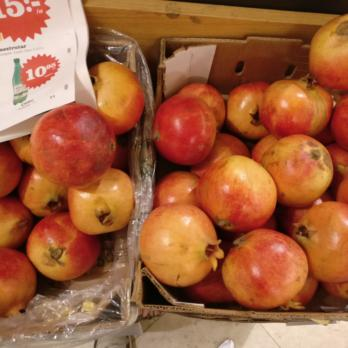

In [9]:
img, cls_idx = ds_train[750]
print(ds_train.classes[cls_idx])
img

### Подготовка к тренировке

In [10]:
N_CLASSES = len(ds_train.classes)

In [11]:
import torchvision.transforms as transforms

In [53]:
def target_transform(x):
    return torch.Tensor([x]).long()[0]


test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Трансформы можно менять - например, можно добавить аугментации

In [68]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ColorJitter(saturation = 0.05, hue = 0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [69]:
ds_train = FoodDataset(DATASET_PATH / 'train', DATASET_PATH / 'classes.csv', transform=train_transform, target_transform=target_transform)
ds_test = FoodDataset(DATASET_PATH / 'test', DATASET_PATH / 'classes.csv', transform=test_transform, target_transform=target_transform)

In [70]:
BATCH_SIZE = 32
NUM_WORKERS = 0

trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)
testloader = torch.utils.data.DataLoader(
    ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

### Построение модели
Используйте не слишком тяжелую pretrained-модель, заморозьте ее и добавьте голову на N классов.

Важно помнить, что для некоторых слоев поведение в train/eval режимах - разное, и от этого зависит "успешность" тюнинга.

In [74]:
from torchvision import models
import torch.nn as nn

DEVICE = torch.device("cuda")
backbone = models.efficientnet_b2(pretrained = True).to(DEVICE)

N_FEATURES = 1408
backbone.classifier = nn.Sequential(nn.Dropout(p=0.4, inplace=True), nn.Linear(N_FEATURES, N_CLASSES, bias=True))

In [75]:
net = backbone

## Лосс

In [76]:
criterion = nn.CrossEntropyLoss()

## Тренировка

Для легкого backbone с замороженными весами на batch=32 скорость train ~ 10 батчей в секунду, а в эпохе ~ 80 батчей.

Тренировка в 50 эпох займет 80batch / 10batch/s * 50ep * 2 \[train + test\] = 800s ~13min

In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.optim import lr_scheduler

In [78]:
def run_1_epoch(net, optimizer, dataloader, criterion, *, device=None):
    running_loss = 0.0
    processed_data = 0
    scores = []
    y_labels = []
    metrics = {'f1_score': None, 'precision': None, 'recall': None}

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        y_labels.extend(labels.cpu().numpy())
        scores.extend(preds.cpu().detach().numpy())
        running_loss += loss.item() * inputs.size(0)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data

    metrics['precision'] = precision_score(scores, y_labels, average='macro')
    metrics['recall'] = recall_score(scores, y_labels, average='macro')
    metrics['f1_score'] = f1_score(scores, y_labels, average='macro')
    metrics['accuracy'] = accuracy_score(scores, y_labels)

    return train_loss, metrics


def eval_1_epoch(model, val_loader, criterion, *, device=None):
    model.eval()
    running_loss = 0.0
    processed_size = 0

    scores = []
    y_labels = []
    metrics = {'f1_score': None, 'precision': None, 'recall': None}

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        y_labels.extend(labels.cpu().numpy())
        scores.extend(preds.cpu().numpy())
        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size

    metrics['precision'] = precision_score(scores, y_labels, average='macro')
    metrics['recall'] = recall_score(scores, y_labels, average='macro')
    metrics['f1_score'] = f1_score(scores, y_labels, average='macro')
    metrics['accuracy'] = accuracy_score(scores, y_labels)

    return val_loss, metrics

In [79]:
#!g2.mig
gpu = torch.device('cuda')
net = net.to(gpu)
opt = torch.optim.Adam(net.parameters(), lr=3e-5)

In [80]:
train_losses = []
train_metrics_history = {'f1_score': [], 'precision': [], 'recall': []}
val_losses = []
val_metrics_history = {'f1_score': [], 'precision': [], 'recall': []}

logs = []
losses_history = []
epochs = 10

log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

with tqdm(desc="epoch", total=epochs) as pbar_outer:

    scheduler = lr_scheduler.StepLR(opt, step_size=3, gamma=0.4)
    for epoch in range(epochs):
        train_loss, train_metrics = run_1_epoch(net, opt, trainloader, criterion, device=DEVICE)

        train_metrics_history['f1_score'].append(train_metrics['f1_score'])
        train_metrics_history['precision'].append(train_metrics['precision'])
        train_metrics_history['recall'].append(train_metrics['recall'])

        train_losses.append(train_loss)

        print("loss", train_loss)

        val_loss, val_metrics = eval_1_epoch(net, testloader, criterion, device=DEVICE)

        val_metrics_history['f1_score'].append(val_metrics['f1_score'])
        val_metrics_history['precision'].append(val_metrics['precision'])
        val_metrics_history['recall'].append(val_metrics['recall'])

        val_losses.append(val_loss)

        train_acc = train_metrics['accuracy']
        val_acc = val_metrics['accuracy']

        scheduler.step()
        pbar_outer.update(1)

        log = log_template.format(ep=epoch+1, t_loss=train_loss,\
                                        v_loss=val_loss, t_acc=train_acc, v_acc=val_acc)
        logs.append(log)
        losses_history.append((train_loss, val_loss))
        tqdm.write(log)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.5649367823745264


epoch:  10%|█         | 1/10 [00:54<08:06, 54.04s/it]


Epoch 001 train_loss: 3.5649 val_loss 3.3032 train_acc 0.1261 val_acc 0.3308


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss 2.1368240016879456


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch:  20%|██        | 2/10 [01:47<07:07, 53.46s/it]


Epoch 002 train_loss: 2.1368 val_loss 1.4951 train_acc 0.4894 val_acc 0.5771


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


loss 0.6019262487689654


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
epoch:  30%|███       | 3/10 [02:46<06:33, 56.16s/it]


Epoch 003 train_loss: 0.6019 val_loss 0.7569 train_acc 0.8432 val_acc 0.7811
loss 0.15887365237329945


epoch:  40%|████      | 4/10 [03:48<05:50, 58.46s/it]


Epoch 004 train_loss: 0.1589 val_loss 0.6694 train_acc 0.9595 val_acc 0.8056
loss 0.09254567022576476


epoch:  50%|█████     | 5/10 [04:51<05:00, 60.09s/it]


Epoch 005 train_loss: 0.0925 val_loss 0.6731 train_acc 0.9784 val_acc 0.8036
loss 0.0570899240221038


epoch:  60%|██████    | 6/10 [05:51<03:59, 59.98s/it]


Epoch 006 train_loss: 0.0571 val_loss 0.6752 train_acc 0.9875 val_acc 0.8161
loss 0.037441762463387214


epoch:  70%|███████   | 7/10 [06:50<02:59, 59.78s/it]


Epoch 007 train_loss: 0.0374 val_loss 0.6067 train_acc 0.9905 val_acc 0.8274
loss 0.035026380160089694


epoch:  80%|████████  | 8/10 [07:56<02:03, 61.65s/it]


Epoch 008 train_loss: 0.0350 val_loss 0.6550 train_acc 0.9936 val_acc 0.8165
loss 0.0281457951997943


epoch:  90%|█████████ | 9/10 [09:06<01:04, 64.21s/it]


Epoch 009 train_loss: 0.0281 val_loss 0.6359 train_acc 0.9943 val_acc 0.8209
loss 0.026779319341717796


epoch: 100%|██████████| 10/10 [10:05<00:00, 60.53s/it]


Epoch 010 train_loss: 0.0268 val_loss 0.6742 train_acc 0.9947 val_acc 0.8209


## Метрики и лосс

In [81]:
print(f"Train Precision/Recall: {train_metrics_history['precision'][-1]}/{train_metrics_history['recall'][-1]}, \nTest Precision/Recall {val_metrics_history['precision'][-1]}/{val_metrics_history['recall'][-1]}")

Train Precision/Recall: 0.993094327199687/0.9942389192100076, 
Test Precision/Recall 0.7337116824670349/0.790057187895271


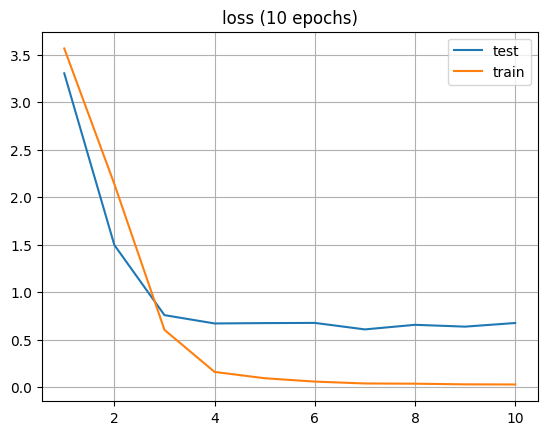

In [85]:
#### График функции потерь ####

from matplotlib import pyplot as plt
epochs = np.arange(1, epochs + 1)
plt.plot(epochs, val_losses, label='test')
plt.plot(epochs, train_losses, label='train')

plt.title(f'loss ({epoch + 1} epochs)')
plt.grid()
plt.legend()

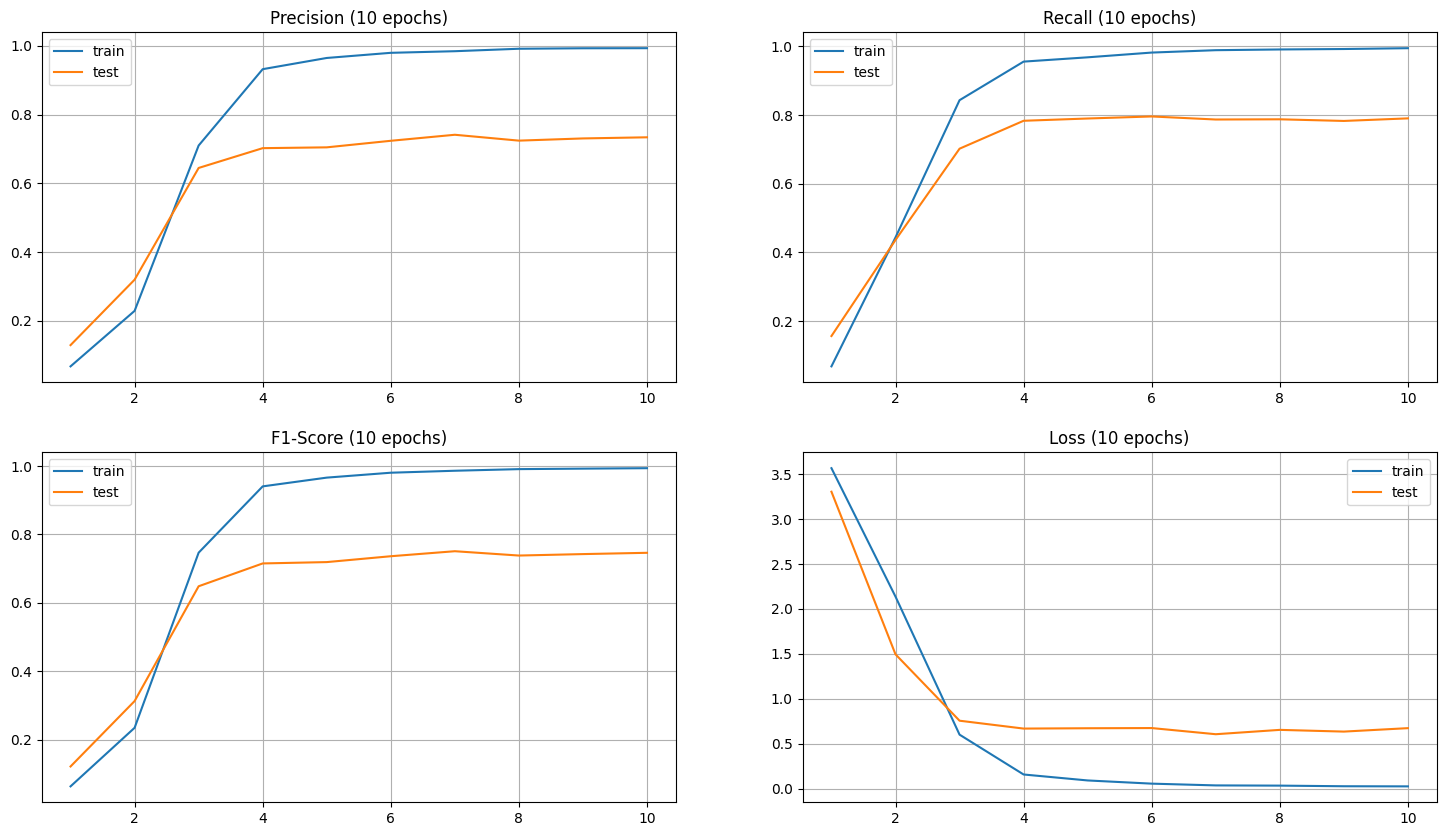

In [95]:
#### Графики метрик ####

fig, axes = plt.subplots(2, 2, figsize=(18,10))

axes[0][0].plot(epochs, train_metrics_history['precision'], label='train')
axes[0][0].plot(epochs, val_metrics_history['precision'], label='test')
axes[0][0].set_title('Precision (10 epochs)')
axes[0][0].grid()
axes[0][0].legend()

axes[0][1].plot(epochs, train_metrics_history['recall'], label='train')
axes[0][1].plot(epochs, val_metrics_history['recall'], label='test')
axes[0][1].set_title('Recall (10 epochs)')
axes[0][1].grid()
axes[0][1].legend()

axes[1][0].plot(epochs, train_metrics_history['f1_score'], label='train')
axes[1][0].plot(epochs, val_metrics_history['f1_score'], label='test')
axes[1][0].set_title('F1-Score (10 epochs)')
axes[1][0].grid()
axes[1][0].legend()

axes[1][1].plot(epochs, train_losses, label='train')
axes[1][1].plot(epochs, val_losses, label='test')
axes[1][1].set_title('Loss (10 epochs)')
axes[1][1].grid()
axes[1][1].legend()


### Окружение
Список пакетов в python виртуальной машины

In [ ]:
! cat /etc/lsb-release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=18.04
DISTRIB_CODENAME=bionic
DISTRIB_DESCRIPTION="Ubuntu 18.04.6 LTS"


In [ ]:
! python -V

Python 3.10.12


In [ ]:
! pip list

Package                       Version      Editable project location
----------------------------- ------------ ----------------------------------------------------------
a4_course_cvdl_t1             0.2.0        D:\edu\course_cvdl\task1
a4_course_cvdl_t2             0.2.0        D:\edu\course_cvdl\task2
abbyy-course-cvdl-t1          0.1.0
about-time                    4.2.1
absl-py                       1.4.0
addict                        2.4.0
aiohttp                       3.8.5
aiohttp-retry                 2.8.3
aiosignal                     1.3.1
alabaster                     0.7.13
albumentations                1.3.1
alembic                       1.12.0
alive-progress                3.1.4
amqp                          5.1.1
annotated-types               0.5.0
antlr4-python3-runtime        4.9.3
anyio                         3.7.1
appdirs                       1.4.4
argcomplete                   3.1.1
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow